**Author:** Regina Hoo

**Institution:** Wellcome Sanger institute

**April, 2023**

---

### Subset out trophozoites stages

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
import glob
import matplotlib.pyplot as pl


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/EXP/label_transfer/'

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0


'/opt/conda/bin/python'

### Read pS6 output where idc was labeled into clusters

In [3]:
adata= sc.read('./output/rna3_annotate_leiden.h5ad')
adata.X.shape


(205631, 5515)

In [4]:
adata

AnnData object with n_obs × n_vars = 205631 × 5515
    obs: 'sample', 'stage', 'id', 'proc', 'sample.1', 'p_batch', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'sample_barcode', 'stage_1', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'is_doublet_0.05', 'leiden_harmony', 'idc', 'probabilities', 'sample.2', 'idc_new'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'pf_only', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden_harmony', 'id_colors', 'idc_colors', 'idc_new_colors', 'leiden', 'leiden_harmony_colors', 'neighbors', 'p_batch_colors', 'pca', 'proc_colors', 'sample.1_colors', 'sample.2_colors', 'stage_0_colors', 'stage_1_colors', 'stage_colors', 'uma

In [5]:
#Early_troph
adataET = adata[adata.obs['idc_new'].isin(['2_early_trophozoite'])]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
#Late_troph
adataLT = adata[adata.obs['idc_new'].isin(['3_late_trophozoite'])]

In [7]:
adataET.write ('./output/rna4_annotate_ET.h5ad')

In [8]:
adataLT.write ('./output/rna4_annotate_LT.h5ad')

In [7]:
#For TF-IDF
import episcanpy as epi
from sklearn.feature_extraction.text import TfidfTransformer 

In [8]:
def runTF_IDF(adata, groupby, method='wilcoxon'):
    
    '''
    Function to run TF-IDF and DE analysis. TF-IDF means term-frequency times inverse document-frequency. 
    Its goal is to scale down the impact of tokens that occur very frequently (i.e. less informative)
    than features that occur in a small fraction of the training corpus.
    The the function applies a DE analysis.
    
    Parameters:
        adata: anndata object with cells.
        groupby: column name in .obs to make the DE comparison.
        method: method to use for Differential expression.
    
    Return:
        anndata object with the DE genes stored in adata.uns['rank_genes_groups']
        
    '''
    counts=adata
    
    #counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)


    #-- Binarize counts matrix (1 if expressed, 0 otherwise)
    adata_bin = epi.pp.binarize(counts, copy=True)
    adata_bin.X.shape


    #-- Compute TF-IDF
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(adata_bin.X.T)
    adata_bin.X = tfidf.T
    adata_bin.X.shape


    #-- Compute Mann-Withney test with scanpy
    sc.tl.rank_genes_groups(adata_bin, groupby= groupby, use_raw=False, method=method)

    return(adata_bin)

In [9]:
adata_bin= runTF_IDF(adata, groupby='stage_1', method='wilcoxon')

ranking genes
... storing 'sample.2' as categorical
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:19)


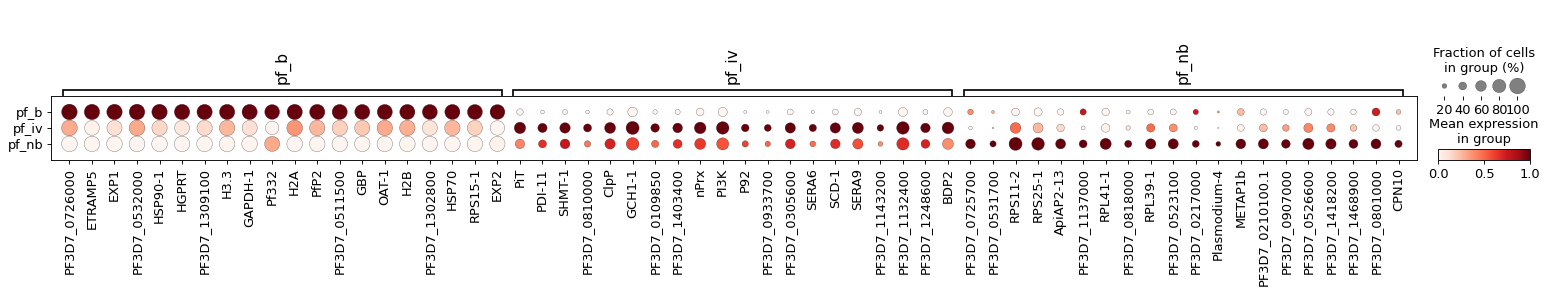

In [12]:
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=20, dendrogram=False,standard_scale='var')